# Model Based RL

```
Environment -> Model Network -> Policy Network -
     ^________________________________________ |
```

Environment
    Real world
    No Train
    Outputs a state (Represents the current environment)
    Takes in an action
        Outputs a new state (Environment that reacted to that action)
        
Model Network
    Learned world
    Training to mimic real world
    Takes in a state and action
    Outputs a new state 
    
Policy Network
    Learned action making
    Training to take action with best reward
    Inputs state (be it from the model or real world)
    Output action

Let's start programming!

In [9]:
import numpy as np
import cPickle as pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Cause I like the distinction between xrange and range
try:
    xrange = xrange
except:
    xrange = range

In [10]:
import gym
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


## Let's make some Harry Potters! (HP -> Hyperparameters)

In [24]:
H             = 8     # Hidden Layers nuerons
learning_rate = 1e-2
beta          = 1e-4  # Weight for l2 regularization
gamma         = 0.99  # Discount factor
decay_rate    = 0.99  # For RMSProb Leaky sum of grad^2
resume        = False # resume from previous checkpoint
model_bs      = 3     # Batch size from model
real_bs       = 3     # Batch size from real environment
D             = 4     # input dimensions
xi = tf.contrib.layers.xavier_initializer

## Policy Network

In [25]:
reset_graph()

# Infer
with tf.variable_scope("policy/infer"):
    observations = tf.placeholder(tf.float32, [None, 4], name="input_x")
    W1 = tf.get_variable("W1", shape=[4, H], initializer=xi())
    layer1 = tf.nn.relu(tf.matmul(observations, W1))
    W2 = tf.get_variable("W2", shape=[H, 1], initializer=xi())
    score = tf.matmul(layer1, W2)
    prob = tf.nn.sigmoid(score)

# Train
with tf.variable_scope("policy/train"):
    tvars= tf.trainable_variables()
    input_y = tf.placeholder(tf.float32, [None,1], name="input_y")
    advantages = tf.placeholder(tf.float32, name="reward_signal")
    adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
    W1Grad = tf.placeholder(tf.float32, name="batch_grad1")
    W2Grad = tf.placeholder(tf.float32, name="batch_grad2")
    batch_grad = [W1Grad, W2Grad]
    loglik = tf.log(input_y*(input_y-prob) + (1 - input_y)*(input_y+prob))
    loss = -tf.reduce_mean(loglik * advantages)
    policy_reg = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)
    loss = tf.reduce_mean(loss + beta * policy_reg)
    newGrads = tf.gradients(loss, tvars)
    updateGrads = adam.apply_gradients(zip(batch_grad, tvars))

## Model Network

In [26]:
# This will be a 2 layer network (5->256->256->5)
mH = 256

with tf.variable_scope("model/infer"):
    prev_state = tf.placeholder(tf.float32, [None, 5], name="prev_state")
    with tf.variable_scope("L1"):
        W1M = tf.get_variable("W1M", shape=[5, mH], initializer=xi())
        b1M = tf.Variable(tf.zeros([mH]), name="b1M")
        layer1M = tf.nn.relu(tf.matmul(prev_state, W1M) + b1M)
    with tf.variable_scope("L2"):
        W2M = tf.get_variable("W2M", shape=[mH, mH], initializer=xi())
        b2M = tf.Variable(tf.zeros([mH]), name="b2M")
        layer2M = tf.nn.relu(tf.matmul(layer1M, W2M) + b2M)
    with tf.variable_scope("output"):
        wO = tf.get_variable("wO", shape=[mH, 4], initializer=xi())
        wR = tf.get_variable("wR", shape=[mH, 1], initializer=xi())
        wD = tf.get_variable("wD", shape=[mH, 1], initializer=xi())
        
        bO = tf.Variable(tf.zeros([4]),name="bO")
        bR = tf.Variable(tf.zeros([1]),name="bR")
        bD = tf.Variable(tf.ones([1]),name="bD")

        predicted_observation = tf.matmul(layer2M,wO,name="predicted_observation") + bO
        predicted_reward = tf.matmul(layer2M,wR,name="predicted_reward") + bR
        predicted_done = tf.sigmoid(tf.matmul(layer2M,wD,name="predicted_done") + bD)

with tf.variable_scope("model/train"):
    true_observation = tf.placeholder(tf.float32, [None, 4], name="true_observation")
    true_reward = tf.placeholder(tf.float32, [None, 1], name="true_reward")
    true_done = tf.placeholder(tf.float32, [None, 1], name="true_done")
    with tf.variable_scope("loss"):
        predicted_state = tf.concat([predicted_observation, 
                                     predicted_reward, 
                                     predicted_done], 1)
        observation_loss = tf.squared_difference(true_observation, predicted_observation)
        reward_loss = tf.squared_difference(true_reward, predicted_reward)
        done_loss = tf.squared_difference(true_done, predicted_done)
        
        model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss)
        model_reg = tf.nn.l2_loss(W1M) + \
                      tf.nn.l2_loss(W2M) + \
                      tf.nn.l2_loss(wO) + \
                      tf.nn.l2_loss(wR) + \
                      tf.nn.l2_loss(wD)
        model_loss = tf.reduce_mean(model_loss + beta * model_reg)
    
    with tf.variable_scope("optimize"):
        modelAdam = tf.train.AdamOptimizer(learning_rate=learning_rate)
        updateModel = modelAdam.minimize(model_loss)

In [27]:
def resetGradBuffer(gradBuffer):
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer
        
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r


# This function uses our model to produce a new state when given a previous 
# state and action.
def stepModel(sess, xs, action):
    toFeed = np.reshape(np.hstack([xs[-1][0],np.array(action)]),[1,5])
    myPredict = sess.run([predicted_state],
                         feed_dict={prev_state: toFeed})
    reward = myPredict[0][:,4]
    observation = myPredict[0][:,0:4]
    observation[:,0] = np.clip(observation[:,0],-2.4,2.4)
    observation[:,2] = np.clip(observation[:,2],-0.4,0.4)
    doneP = np.clip(myPredict[0][:,5],0,1)
    if doneP > 0.1 or len(xs)>= 300:
        done = True
    else:
        done = False
    return observation, reward, done

# Train the Policy and the Model

In [28]:
xs,drs,ys,ds = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1
init = tf.global_variables_initializer()
batch_size = real_bs

drawFromModel = False # When set to True, will use model for observations
trainTheModel = True # Whether to train the model
trainThePolicy = False # Whether to train the policy
switch_point = 1

# Launch the graph
with tf.Session() as sess:
    rendering = False
    sess.run(init)
    observation = env.reset()
    x = observation
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 5000:
        # Start displaying environment once performance is acceptably high.
        if (reward_sum/batch_size > 150 and drawFromModel == False) or \
            rendering == True : 
            env.render()
            rendering = True
            
        x = np.reshape(observation,[1,4])

        tfprob = sess.run(prob,feed_dict={observations: x})
        action = 1 if np.random.uniform() < tfprob else 0

        # record various intermediates (needed later for backprop)
        xs.append(x) 
        y = 1 if action == 0 else 0 
        ys.append(y)
        
        # step the  model or real environment and get new measurements
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess,xs,action)
                
        reward_sum += reward
        
        # record reward (has to be done after we call step() to get 
        # reward for previous action)
        ds.append(done*1)
        drs.append(reward) 

        if done: 
            
            if drawFromModel == False: 
                real_episodes += 1
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, 
            # and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            xs,drs,ys,ds = [],[],[],[] # reset array memory
            
            if trainTheModel == True:
                actions = np.array([np.abs(y-1) for y in epy][:-1])
                state_prevs = epx[:-1,:]
                state_prevs = np.hstack([state_prevs,actions])
                state_nexts = epx[1:,:]
                rewards = np.array(epr[1:,:])
                dones = np.array(epd[1:,:])
                state_nextsAll = np.hstack([state_nexts,rewards,dones])

                feed_dict={prev_state: state_prevs, 
                           true_observation: state_nexts,
                           true_done:dones,
                           true_reward:rewards}
                loss,pState,_ = sess.run([model_loss,
                                          predicted_state,
                                          updateModel],feed_dict)
            if trainThePolicy == True:
                discounted_epr = discount_rewards(epr).astype('float32')
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr /= np.std(discounted_epr)
                tGrad = sess.run(newGrads,
                                 feed_dict={observations: epx, 
                                            input_y: epy, 
                                            advantages: discounted_epr})
                
                # If gradients become too large, end training process
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                for ix,grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
                
            if switch_point + batch_size == episode_number: 
                switch_point = episode_number
                if trainThePolicy == True:
                    sess.run(updateGrads,
                             feed_dict={
                                 W1Grad: gradBuffer[0],
                                 W2Grad: gradBuffer[1]})
                    gradBuffer = resetGradBuffer(gradBuffer)
                
                if reward_sum > 1000:
                    reward_sum = 1000
                running_reward = reward_sum if running_reward is None \
                    else running_reward * 0.99 + reward_sum * 0.01
                if drawFromModel == False:
                    print 'Perf: Ep. %f. Reward %f. mean reward %f.'\
                           % (real_episodes,reward_sum/real_bs,running_reward/real_bs)
                    if reward_sum/batch_size > 200:
                        print "Finished training"
                        break
                reward_sum = 0

                # Once the model has been trained on 100 episodes, we start alternating between training the policy
                # from the model and training the model from the real environment.
                if episode_number > 100:
                    drawFromModel = not drawFromModel
                    trainTheModel = not trainTheModel
                    trainThePolicy = not trainThePolicy
            
            if drawFromModel == True:
                observation = np.random.uniform(-0.1,0.1,[4]) # Generate reasonable starting point
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs
                
print real_episodes

Perf: Ep. 4.000000. Reward 22.000000. mean reward 22.000000.
Perf: Ep. 7.000000. Reward 38.666667. mean reward 22.166667.
Perf: Ep. 10.000000. Reward 15.333333. mean reward 22.098333.
Perf: Ep. 13.000000. Reward 15.666667. mean reward 22.034017.
Perf: Ep. 16.000000. Reward 19.666667. mean reward 22.010343.
Perf: Ep. 19.000000. Reward 30.000000. mean reward 22.090240.
Perf: Ep. 22.000000. Reward 17.333333. mean reward 22.042671.
Perf: Ep. 25.000000. Reward 30.666667. mean reward 22.128911.
Perf: Ep. 28.000000. Reward 12.333333. mean reward 22.030955.
Perf: Ep. 31.000000. Reward 19.666667. mean reward 22.007312.
Perf: Ep. 34.000000. Reward 19.666667. mean reward 21.983906.
Perf: Ep. 37.000000. Reward 26.333333. mean reward 22.027400.
Perf: Ep. 40.000000. Reward 21.000000. mean reward 22.017126.
Perf: Ep. 43.000000. Reward 29.666667. mean reward 22.093621.
Perf: Ep. 46.000000. Reward 27.000000. mean reward 22.142685.
Perf: Ep. 49.000000. Reward 39.333333. mean reward 22.314591.
Perf: Ep. 

Perf: Ep. 403.000000. Reward 30.666667. mean reward 81.978172.
Perf: Ep. 406.000000. Reward 31.666667. mean reward 82.726112.
Perf: Ep. 409.000000. Reward 63.333333. mean reward 81.848328.
Perf: Ep. 412.000000. Reward 40.333333. mean reward 83.885948.
Perf: Ep. 415.000000. Reward 52.666667. mean reward 85.839775.
Perf: Ep. 418.000000. Reward 38.000000. mean reward 84.640320.
Perf: Ep. 421.000000. Reward 39.333333. mean reward 86.217529.
Perf: Ep. 424.000000. Reward 29.666667. mean reward 87.421448.
Perf: Ep. 427.000000. Reward 26.333333. mean reward 86.876091.
Perf: Ep. 430.000000. Reward 20.000000. mean reward 88.035271.
Perf: Ep. 433.000000. Reward 24.666667. mean reward 89.348869.
Perf: Ep. 436.000000. Reward 52.000000. mean reward 90.715034.
Perf: Ep. 439.000000. Reward 65.333333. mean reward 89.742554.
Perf: Ep. 442.000000. Reward 63.333333. mean reward 88.900169.
Perf: Ep. 445.000000. Reward 38.000000. mean reward 90.372002.
Perf: Ep. 448.000000. Reward 45.333333. mean reward 90.

Perf: Ep. 793.000000. Reward 92.666667. mean reward 120.049065.
Perf: Ep. 796.000000. Reward 123.333333. mean reward 120.248192.
Perf: Ep. 799.000000. Reward 147.000000. mean reward 122.073578.
Perf: Ep. 802.000000. Reward 104.666667. mean reward 123.553703.
Perf: Ep. 805.000000. Reward 135.000000. mean reward 125.744987.


KeyboardInterrupt: 

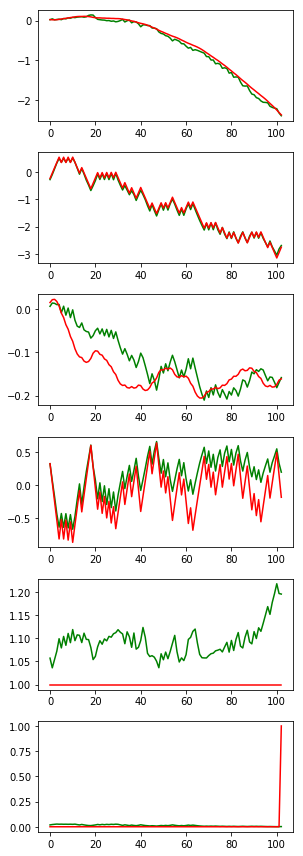

In [29]:
plt.figure(figsize=(8, 12))
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(pState[:,i], color="g")
    plt.subplot(6,2,2*i+1)
    plt.plot(state_nextsAll[:,i], color='r')
plt.tight_layout()